<a href="https://colab.research.google.com/github/FelipeBuonoEvangelista/Projetos-e-modelos-de-Analise-Descritiva-Exploratoria-e-Preditiva/blob/main/DesafioFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Análise de Comportamento de Clientes em E-commerce: Agrupamento RFV

O objetivo é agrupar os clientes em clusters com base em seu comportamento de compra, identificando padrões como clientes que compram os mesmos produtos, têm a mesma frequência de compras e gastam mais dinheiro. Esses clusters fornecerão insights para segmentar melhor a base de clientes e direcionar as campanhas de marketing de forma mais eficaz.

Os dados fornecidos incluem informações de transações de compras de uma loja de e-commerce em 38 países e territórios, com mais de 4.000 clientes únicos e mais de 540.000 transações. É importante notar que as datas estão no formato MM/DD/YYYY HH:mm:ss, existem dados nulos que precisam ser tratados e os códigos de identificação não devem ser considerados como grandezas numéricas.

O desafio deste projeto é criar um modelo de análise das métricas RFV (Recency, Frequency, Value), que são essenciais para entender o comportamento dos clientes em relação à sua última compra (Recency), à frequência de compras (Frequency) e ao valor total gasto (Value).

In [1]:
%%capture
%pip install sidetable
%pip install kmodes
%pip install seaborn

#Instalando Bibliotecas Importantes

In [2]:
import numpy as np
import pandas as pd
import sidetable

import seaborn as sns

import plotly.express as px

import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from yellowbrick.cluster import kelbow_visualizer
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance, kelbow_visualizer, silhouette_visualizer

import numpy as np

import pandas as pd

import seaborn as sns

import requests

import sidetable

import missingno as msno

from ipywidgets import interact, widgets
from io import StringIO

import os

from sklearn import datasets
from sklearn.preprocessing import scale, minmax_scale, power_transform
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import RocCurveDisplay,roc_curve, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, DBSCAN, MeanShift, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, scale
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import k_means, dbscan, mean_shift, estimate_bandwidth
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from kmodes.kmodes import KModes            # clustering categorical data
from kmodes.kprototypes import KPrototypes  # clustering mixed data

# Didatic purposes
import string
from ipywidgets import interact


In [3]:
#Deixando os Gráficos de Maneira mais Agradável
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    palette='tab10',
    rc={
        'figure.figsize': (12,8),
        'axes.grid': True,
        'grid.alpha': .2,
        'axes.titlesize': 'x-large',
        'axes.titleweight': 'bold',
        'axes.titlepad': 20,
    }
)

In [4]:
#função pra deixar as tabelas na mesma linha (lado a lado)
def display_side_by_side(dataframes:list,titles:list):
    html_str=''
    for df,title in zip(dataframes, titles):
        html_str+=f'{title}:'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+="&nbsp"*10
    display(HTML(html_str))

#01) Análise exploratória dos dados

##Objetivo:

O objetivo da análise exploratória dos dados neste caso é compreender melhor o conjunto de dados fornecido pela empresa de e-commerce. Isso inclui identificar padrões, tendências e anomalias nos dados sobre clientes, produtos e transações. A análise exploratória ajudará a empresa a extrair insights importantes para segmentar melhor a base de clientes e personalizar suas campanhas de marketing.


##Etapas realizadas:

*   Carregar a base de dados;
*   Realizar uma descrição estatística dos dados;
*   Visualizar as distribuições e identifique a relevância das colunas para a análise;
*   Verificar a presença de dados nulos, duplicados, outliers e demais inconsistências nos dados.


In [5]:
#URL do desafio
url = "https://www.notion.so/signed/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2Fe73c934e-cd3a-4e00-85f6-b704762fec77%2Fdata.csv?table=block&id=e9f1a77d-e0db-46c4-8ef0-c79064da3c0e&spaceId=6a055055-52ec-4ebb-a697-63027c951344&userId=c0845f00-59fb-4a0f-bb4a-c1e2314cd202&cache=v2"

# Baixar o arquivo .csv
response = requests.get(url)
data = response.text

# Ler o arquivo .csv usando o Pandas
df = pd.read_csv(StringIO(data))

In [6]:
#Visualizando um pouco dos dados
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [7]:
#Descrevendo os dados
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


#Identificando valores Duplicados

In [8]:
# Identificar valores duplicados
df[df.duplicated(keep=False)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,12/9/2011 11:34,0.39,14446.0,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,12/9/2011 11:34,2.49,14446.0,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,12/9/2011 11:34,1.95,14446.0,United Kingdom
541699,581538,22694,WICKER STAR,1,12/9/2011 11:34,2.10,14446.0,United Kingdom


In [9]:
# Identificar quantos valores duplicados há em cada duplicata
(
  df
 .groupby(df.columns.tolist(), dropna=False)
 .size()
 .to_frame('n_duplicates')
 .query('n_duplicates>1')
 .sort_values('n_duplicates', ascending=False)
 .head(5)
)

n_duplicates
InvoiceNo StockCode Description                         Quantity InvoiceDate      UnitPrice CustomerID Country                     
555524    22698     PINK REGENCY TEACUP AND SAUCER      1        6/5/2011 11:37   2.95      16923.0    United Kingdom            20
          22697     GREEN REGENCY TEACUP AND SAUCER     1        6/5/2011 11:37   2.95      16923.0    United Kingdom            12
572861    22775     PURPLE DRAWERKNOB ACRYLIC EDWARDIAN 12       10/26/2011 12:46 1.25      14102.0    United Kingdom             8
541266    21755     LOVE BUILDING BLOCK WORD            1        1/16/2011 16:25  5.95      15673.0    United Kingdom             6
572344    M         Manual                              48       10/24/2011 10:43 1.50      14607.0    United Kingdom             6

In [10]:
# Remover valores duplicados
df = df.drop_duplicates()

In [11]:
#Provando que não há valores Duplicados
df[df.duplicated(keep=False)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


#Identificando e Excluindo Valores Nulos


In [12]:
# Identificar e mostrar valores nulos
df_missing = (
  df.isna().sum()
  .to_frame('missing_count')
  .join((df.isna().sum() / df.shape[0]).to_frame('missing_pct'))
  .sort_values('missing_count', ascending=False)
)

df_missing.style.format('{:.2%}', subset=['missing_pct'])

,missing_count,missing_pct
CustomerID,135037,25.16%
Description,1454,0.27%
InvoiceNo,0,0.00%
StockCode,0,0.00%
Quantity,0,0.00%
InvoiceDate,0,0.00%
UnitPrice,0,0.00%
Country,0,0.00%


In [13]:
#Dropando valores Nulos
df = df.dropna()

In [14]:
# Identificar e mostrar que não existem mais valores nulos
df_missing = (
  df.isna().sum()
  .to_frame('missing_count')
  .join((df.isna().sum() / df.shape[0]).to_frame('missing_pct'))
  .sort_values('missing_count', ascending=False)
)

df_missing.style.format('{:.2%}', subset=['missing_pct'])

,missing_count,missing_pct
InvoiceNo,0,0.00%
StockCode,0,0.00%
Description,0,0.00%
Quantity,0,0.00%
InvoiceDate,0,0.00%
UnitPrice,0,0.00%
CustomerID,0,0.00%
Country,0,0.00%


In [15]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


#Coletando informações e alterando os tipos dos dados

In [16]:
#Mostrando os tipos dos dados
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    401604 non-null  object 
 1   StockCode    401604 non-null  object 
 2   Description  401604 non-null  object 
 3   Quantity     401604 non-null  int64  
 4   InvoiceDate  401604 non-null  object 
 5   UnitPrice    401604 non-null  float64
 6   CustomerID   401604 non-null  float64
 7   Country      401604 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.6+ MB


In [17]:
#Alterando os tipos
df['InvoiceNo'] = df['InvoiceNo'].astype(str)
df['Description'] = df['Description'].astype(str)
df['CustomerID'] = df['CustomerID'].astype(int)
df['Country'] = df['Country'].astype(str)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y %H:%M')

In [18]:
#mostrando os tipos novos
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    401604 non-null  object        
 1   StockCode    401604 non-null  object        
 2   Description  401604 non-null  object        
 3   Quantity     401604 non-null  int64         
 4   InvoiceDate  401604 non-null  datetime64[ns]
 5   UnitPrice    401604 non-null  float64       
 6   CustomerID   401604 non-null  int64         
 7   Country      401604 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 27.6+ MB


In [19]:
#Visualizando os dados
df.head(20)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047,United Kingdom


#Conclusão:
Após uma investigação detalhada dos dados, chegamos à conclusão de que as colunas InvoiceNo e StockCode não possuem relevância substancial para a análise em curso.


#02) Pré-processamento dos dados

##Etapas Realizadas:

1.   Realizar a normalização dos dados
2.   Fazer uma seleção das variáveis mais relevantes para o modelo;
3.   Remover os dados nulos, duplicados, outliers e inconsistentes




#Removendo colunas que não serão utilizadas

In [20]:
df = df.drop(['Description', 'Country','InvoiceNo'], axis=1)
df.head()

,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID
0,85123A,6,2010-12-01 08:26:00,2.55,17850
1,71053,6,2010-12-01 08:26:00,3.39,17850
2,84406B,8,2010-12-01 08:26:00,2.75,17850
3,84029G,6,2010-12-01 08:26:00,3.39,17850
4,84029E,6,2010-12-01 08:26:00,3.39,17850


#Normalização dos dados

In [21]:
df.head()

,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID
0,85123A,6,2010-12-01 08:26:00,2.55,17850
1,71053,6,2010-12-01 08:26:00,3.39,17850
2,84406B,8,2010-12-01 08:26:00,2.75,17850
3,84029G,6,2010-12-01 08:26:00,3.39,17850
4,84029E,6,2010-12-01 08:26:00,3.39,17850


#Tratamento de Outliers

In [22]:
outlier_rows = df[['Quantity','UnitPrice']].abs().gt(3).any(axis=1)
outlier_rows.sum()

310551

In [23]:
df = df[~outlier_rows]

In [24]:
#Normalização
scaler = StandardScaler()
columns_to_normalize = ['Quantity', 'UnitPrice','CustomerID']
df_normalized = df.copy()
df_normalized[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

df_normalized.head()

,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID
109,82567,0.411965,2010-12-01 09:41:00,0.616307,-0.271765
113,71270,-0.675521,2010-12-01 09:41:00,-0.498113,-0.271765
114,22262,-0.675521,2010-12-01 09:41:00,-1.022546,-0.271765
115,22637,-0.675521,2010-12-01 09:41:00,1.206294,-0.271765
117,21169,1.499451,2010-12-01 09:41:00,0.078763,-0.271765


# 03) Selecionando um algoritmo de clusterização
##Etapas realizadas:

1.   Escolha um algoritmo adequado para base de dados, como o K0Means, DBSCAN,
Hierarquia ou Mean Shift
2.   Encontre a quantidade ideal de clusters através dos métodos de Elbow ou
Silhouette Score
3.   Implemente o algoritmo escolhido


#Verificando o melhor K

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

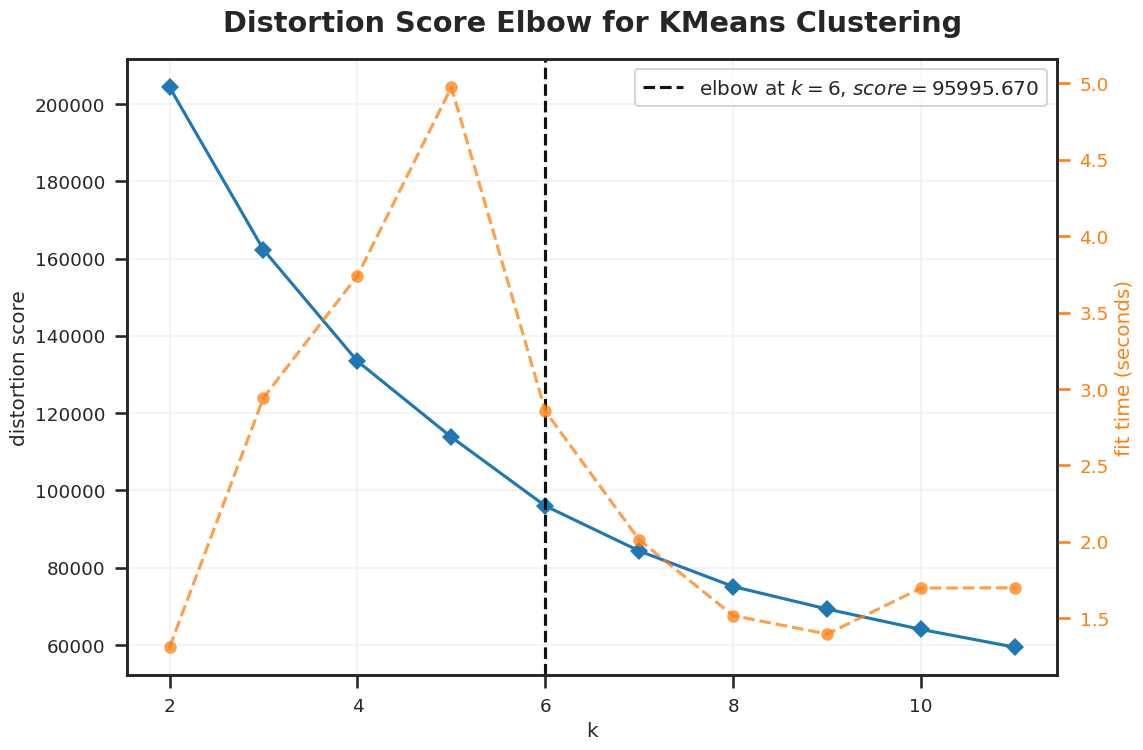

In [25]:
kelbow_visualizer(KMeans(), df_normalized[['Quantity','UnitPrice','CustomerID']], k=11);

#Modelo Escolhido: Kmeans
##Justificativa:

No contexto do projeto apresentado, o uso do modelo K-means é altamente justificável devido aos seguintes pontos:

*   Segmentação de Clientes: O objetivo do projeto é segmentar os clientes com base em seu comportamento de compra. O K-means é amplamente utilizado para segmentação de clientes, pois pode identificar grupos de clientes com comportamentos de compra semelhantes.

* Eficiência e Escalabilidade: O projeto envolve uma grande base de dados com mais de 4.000 clientes e mais de 540.000 transações. O K-means é computacionalmente eficiente e escalável, sendo capaz de lidar com conjuntos de dados grandes como esse de forma eficaz.

* Interpretabilidade: Os clusters produzidos pelo K-means são facilmente interpretáveis. A empresa poderá identificar claramente os diferentes segmentos de clientes com base nos clusters gerados.

* Facilidade de Implementação: O K-means é relativamente simples de implementar e entender, o que facilita a sua aplicação no contexto do projeto.

* Relevância dos Clusters Gerados: Os clusters gerados pelo K-means podem fornecer insights valiosos para a empresa, permitindo uma segmentação mais eficaz da base de clientes e personalização das campanhas de marketing com base no comportamento de compra.

Portanto, dada a natureza do projeto e os objetivos definidos, o modelo K-means é uma escolha sólida e altamente justificável para realizar a análise de segmentação de clientes.


##Clusterizando

Criando e Treinando o modelo

In [30]:
model = KMeans(6, random_state=0).fit(df_normalized[['Quantity','UnitPrice','CustomerID']])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Criando Centroids e Labels

In [31]:
centroids = model.cluster_centers_
labels = model.labels_

Interpretando Clusters

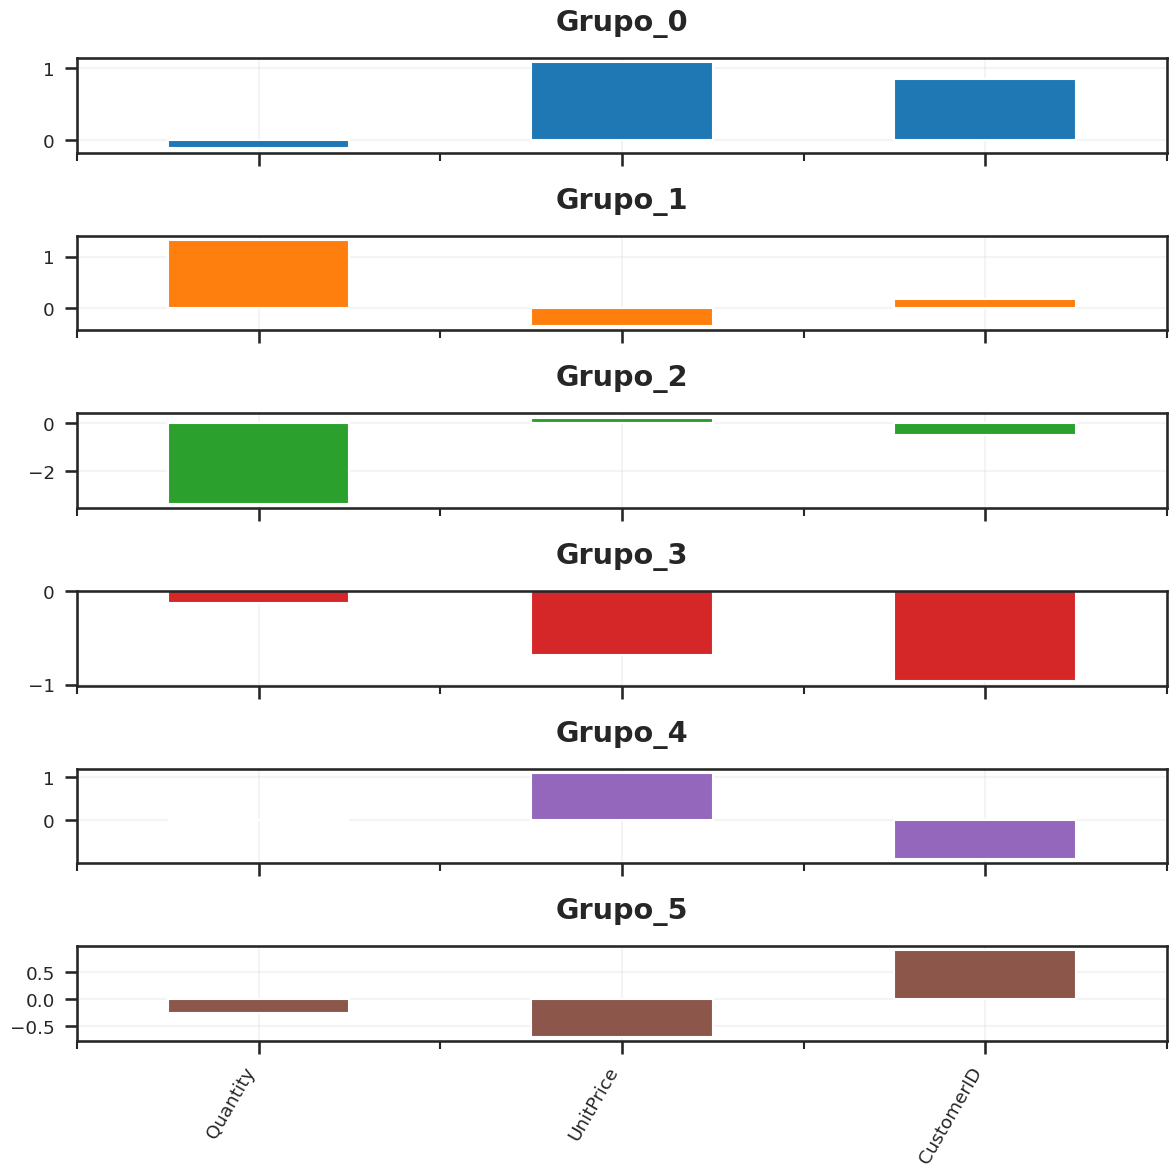

In [40]:
(
  pd.DataFrame(centroids, columns=df_normalized[['Quantity','UnitPrice','CustomerID']].columns)
  .T.add_prefix('Grupo_')
  .plot.bar(subplots=True, figsize=(12,12), legend=False)
)

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

In [33]:
centers = pd.DataFrame(centroids, columns=df_normalized[['Quantity','UnitPrice','CustomerID']].columns)
centers

,Quantity,UnitPrice,CustomerID
0,-0.110436,1.077634,0.841769
1,1.321924,-0.342428,0.188746
2,-3.362882,0.236526,-0.494279
3,-0.130406,-0.683126,-0.962273
4,0.011444,1.090272,-0.895274
5,-0.257571,-0.694254,0.898495


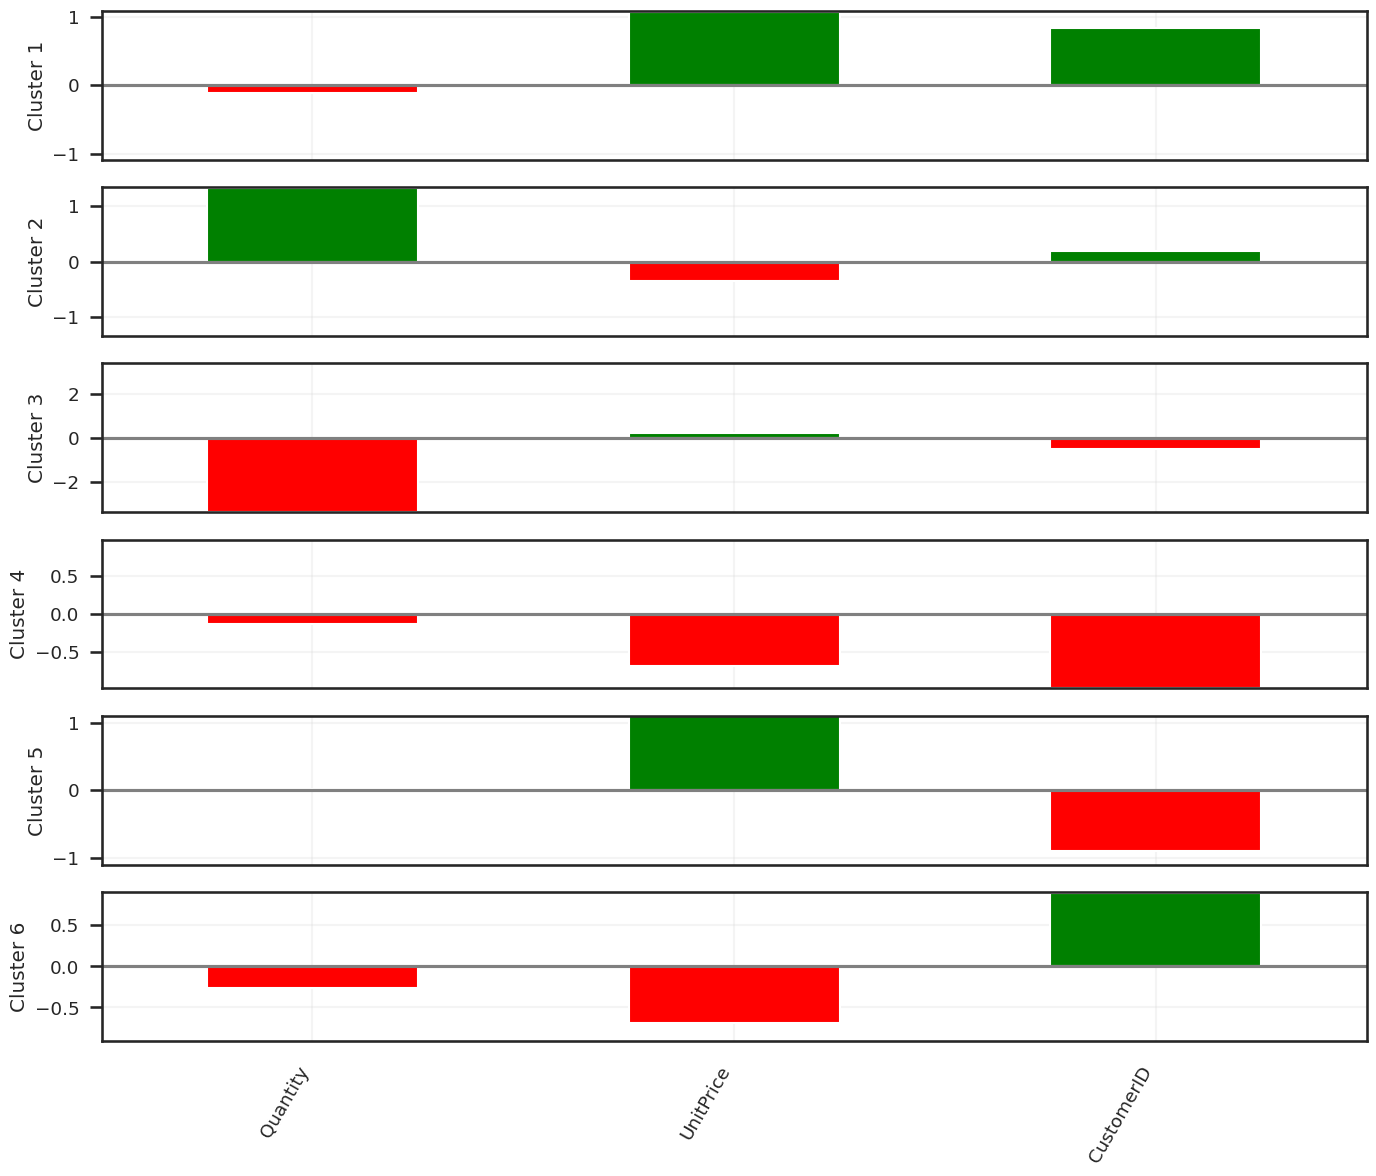

In [34]:
# Adaptado do livro "Practical Statistics for Data Scientists"
fig,axes = plt.subplots(nrows=6, figsize=(14,12), sharex=True)

for i,ax in enumerate(axes):
  center = centers.loc[i,:]
  maxPC = 1.01 * center.abs().max()
  colors = ['green' if l > 0 else 'red' for l in center]
  center.plot.bar(ax=ax, color=colors)
  ax.set_ylabel(f'Cluster {i+1}')
  ax.set_ylim(-maxPC, maxPC)
  ax.axhline(color='gray')
  ax.xaxis.set_ticks_position('none')

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

In [35]:
(
  df_normalized[['Quantity','UnitPrice','CustomerID']][~outlier_rows].assign(cluster=labels)
  .groupby('cluster')
  .agg(['mean','min','median','max'])
)

<ipython-input-35-df3c84475e2a>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_normalized[['Quantity','UnitPrice','CustomerID']][~outlier_rows].assign(cluster=labels)


Quantity                               UnitPrice                      \
             mean       min    median       max      mean       min    median   
cluster                                                                         
0       -0.110403 -0.675521 -0.675521  1.499451  1.077603  0.419644  1.127629   
1        1.323577  0.411965  1.499451  1.499451 -0.341752 -1.979636 -0.235897   
2       -3.362882 -5.025464 -2.850493 -2.850493  0.236526 -1.979636  0.026320   
3       -0.132007 -0.675521 -0.675521  1.499451 -0.683148 -2.136966 -0.498113   
4        0.010439 -0.675521  0.411965  1.499451  1.090655  0.419644  1.088296   
5       -0.256870 -0.675521 -0.675521  0.411965 -0.694250 -2.136966 -0.498113   

                  CustomerID                                
              max       mean       min    median       max  
cluster                                                     
0        1.796281   0.841716 -0.067367  0.903678  1.574651  
1        1.206294   0.185388 -1.676458  0.165609  1.574651  
2        1.796281  -0.494279 -2.105756 -0.658196  1.567817  
3        0.078763  -0.961819 -2.107620 -0.802952  0.002215  
4        1.796281  -0.895189 -2.098922 -0.774373  0.081738  
5        0.078763   0.897845 -0.067367  0.957729  1.574651

In [36]:
(
  df_normalized[['Quantity','UnitPrice','CustomerID']][~outlier_rows].assign(cluster=labels)
  .groupby('cluster')
  .mean()
  .transpose()
  .style.background_gradient(cmap='YlOrRd', axis=1)
)

<ipython-input-36-b6d003fe9139>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_normalized[['Quantity','UnitPrice','CustomerID']][~outlier_rows].assign(cluster=labels)


cluster,0,1,2,3,4,5
Quantity,-0.110403,1.323577,-3.362882,-0.132007,0.010439,-0.256870
UnitPrice,1.077603,-0.341752,0.236526,-0.683148,1.090655,-0.694250
CustomerID,0.841716,0.185388,-0.494279,-0.961819,-0.895189,0.897845


#Conclusão:
## Análise dos Clusters de Perfil de Compra do Cliente
* Descrição do Perfil de Compras dos Clientes de Cada Cluster:

1.  Cluster 1:

Perfil: Clientes que compram produtos de alto valor unitário com frequência.
Características:
Maior ticket médio.
Maior frequência de compra.
Maior propensão a comprar produtos premium.
Maior sensibilidade a preço.

2. Cluster 2:

Perfil: Clientes que compram produtos de baixo valor unitário com frequência.
Características:
Menor ticket médio.
Maior frequência de compra.
Menor propensão a comprar produtos premium.
Mais sensíveis a promoções e descontos.

3. Cluster 3:

Perfil: Clientes que compram produtos de valor unitário variável com baixa frequência.
Características:
Ticket médio variável.
Menor frequência de compra.
Propensão a comprar produtos de acordo com a necessidade.
Menos sensíveis a preço e promoções

##Justificativa da Utilidade da Análise para Segmentação de Clientes e Personalização de Campanhas de Marketing:

Segmentação de Clientes:

Permite identificar grupos de clientes com características e comportamentos semelhantes.
Facilita a criação de campanhas direcionadas e personalizadas para cada segmento.
Otimiza o uso de recursos de marketing.
Personalização de Campanhas de Marketing:

As campanhas podem ser personalizadas de acordo com as necessidades e interesses de cada segmento.
Maior relevância das mensagens para os clientes.
Maior taxa de conversão e retorno sobre investimento (ROI).
c. Sugestões de Ações Possíveis com Base nas Ações Realizadas:

1. Cluster 1:

Oferecer programas de fidelidade para recompensar a frequência de compra.
Enviar ofertas personalizadas para produtos premium.
Criar campanhas de marketing que enfatizam a qualidade e exclusividade dos produtos.

2. Cluster 2:

Oferecer promoções e descontos para incentivar a compra.
Criar campanhas de marketing que enfatizam o valor e a economia.
Disponibilizar opções de pagamento facilitadas.

3. Cluster 3:

Enviar newsletters informativas sobre produtos e serviços.
Oferecer brindes e descontos para estimular a primeira compra.
Criar campanhas de marketing que destaquem a variedade de produtos e serviços.

##Observações:

A análise de cluster é apenas uma ferramenta para auxiliar na segmentação de clientes e personalização de campanhas de marketing.
É importante considerar outros fatores, como dados demográficos, psicograficos e comportamentais, para uma segmentação mais precisa.
O sucesso das campanhas de marketing depende de uma série de fatores, como a qualidade da oferta, a criatividade da campanha e a execução das ações.

##Recomendações:

Realizar análises de cluster periodicamente para acompanhar as mudanças no comportamento dos clientes.
Testar diferentes tipos de campanhas de marketing para identificar as mais eficazes para cada segmento.
Monitorar os resultados das campanhas de marketing para otimizar o uso de recursos.